In [1]:
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as _ssim
from skimage import img_as_float

from generator import get_generator, generator_loss
from discriminator import get_discriminator, discriminator_loss
from metrics import ssim, ssim_mean, norm_1, norm_1_mean, norm_2, norm_2_mean

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Dowloading data for training and testing

In [4]:
X, X_cv, y = [], [], []

for i, image in enumerate(Path("data/data128x128").iterdir()):
    img = cv2.imread(image.__str__())
    X.append(img)
    X_cv.append(cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA))
    if i == 10000:
        break

for i, image in enumerate(Path("data/data256x256").iterdir()):
    img = cv2.imread(image.__str__())
    y.append(img)
    if i == 10000:
        break

print("images loaded")

y = np.asarray(y, dtype=np.float32)
X = np.asarray(X, dtype=np.float32)
X_cv = np.asarray(X_cv, dtype=np.float32)

print("images converted to np")

y = y / 127.5 - 1
X = X / 127.5 - 1
X_cv = X_cv / 127.5 - 1

print("splitting data")

(
    train_images_X,
    test_images_X,
    train_images_y,
    test_images_y,
    train_images_X_cv,
    test_images_X_cv,
) = train_test_split(X, y, X_cv, test_size=0.15)

images loaded
images converted to np
splitting data


### Downloading data only for validation of metrics at the end of training, had to be done since I forgot to save the data split into test and train, so to avoid data leaks we took photos with id over 11k to make sure they were never in train set. 

In [4]:
val_X, val_X_cv, val_y = [], [], []

for i in range(11000, 21000):
    img = cv2.imread(f"data/data128x128/{i}.jpg")
    val_X.append(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    val_X_cv.append(cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA))

for i in range(11000, 21000):
    img = cv2.imread(f"data/data256x256/{i}.jpg", 0)
    val_y.append(img)


val_y = np.asarray(val_y, dtype=np.float32)
val_X = np.asarray(val_X, dtype=np.float32)
val_X_cv = np.asarray(val_X_cv, dtype=np.float32)

val_X = val_X / 127.5 - 1

In [5]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

discriminator = tf.keras.models.load_model("saved_models/disc_SRGAN_10k_e70")
generator = tf.keras.models.load_model("saved_models/gen_SRGAN_10k_e70")

# generator = get_generator()
# discriminator = get_discriminator()

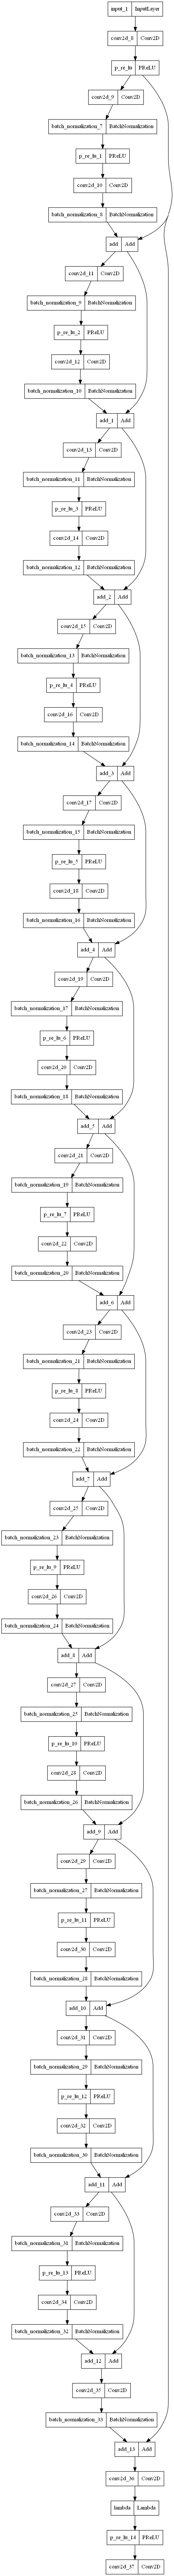

In [18]:
tf.keras.utils.plot_model(generator)

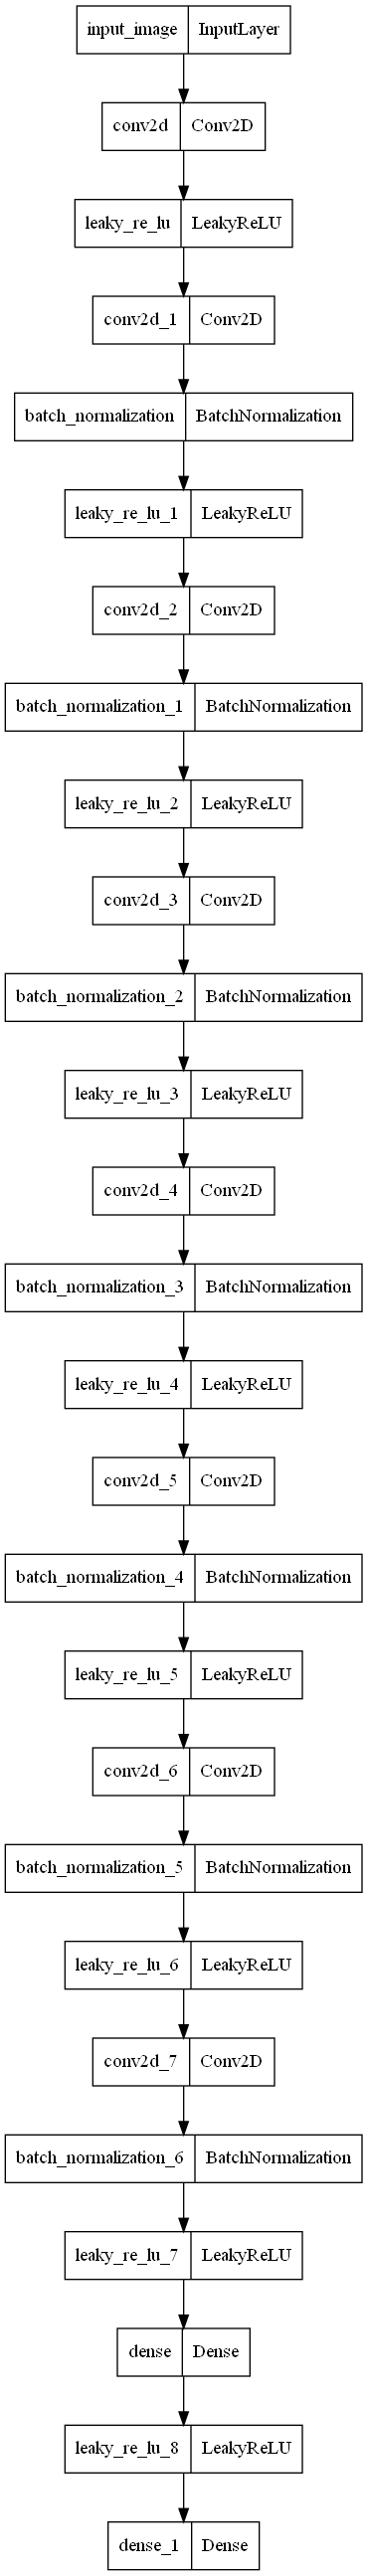

In [17]:
tf.keras.utils.plot_model(discriminator)

In [19]:
@tf.function
def train_step(input_images, targets):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fakes = generator(input_images, training=True)

        disc_fakes = discriminator(fakes, training=True)
        disc_targets = discriminator(targets, training=True)
        
        gen_loss = generator_loss(disc_fakes, fakes, targets)
        disc_loss = discriminator_loss(disc_targets, disc_fakes)

    generator_gradients = gen_tape.gradient(
        gen_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )    

In [20]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
test_log_dir = 'logs/params/' + 'model' + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [22]:
def fit(epochs=1, batch_size = 4):
    total = len(train_images_X)
    steps = total//batch_size
    for epoch in range(1, epochs+1):
        for step in range(steps):
            batch_X = train_images_X[step*batch_size:(step+1)*batch_size]
            batch_y = train_images_y[step*batch_size:(step+1)*batch_size]
            clear_output(wait=True)
            print(f"current batch: {step}/{steps} in epoch {epoch}/{epochs}.")
            train_step(
                batch_X, batch_y
            )
        if not epoch % 5:
            generator.save(f"saved_models/testing/gen_SRGAN_10k_e{epoch}")
            discriminator.save(f"saved_models/testing/disc_SRGAN_10k_e{epoch}")
        
        gen_images = []

        for gen_img in test_X:
            gen_out = generator(gen_img.reshape(1, 128, 128, 3), training=False)
            gen_img_gs = cv2.cvtColor(out_to_img(gen_out)*255, cv2.COLOR_RGB2GRAY)
            gen_images.append(gen_img_gs)
        
        gen_images = np.asarray(gen_images, dtype=np.float32)
        
        ssim_cv_target_mean = ssim_mean(test_X_cv, test_y)
        ssim_gen_target_mean = ssim_mean(gen_images, test_y)
        
        norm_1_cv_target_mean = norm_1_mean(test_X_cv, test_y)
        norm_1_gen_target_mean = norm_1_mean(gen_images, test_y)
        norm_2_cv_target_mean = norm_2_mean(test_X_cv, test_y)
        norm_2_gen_target_mean = norm_2_mean(gen_images, test_y)
            
        with test_summary_writer.as_default():
            tf.summary.scalar('ssim_cv_target', ssim_cv_target_mean, step=epoch)
            tf.summary.scalar('ssim_gen_target', ssim_gen_target_mean, step=epoch)
            tf.summary.scalar('norm_1_cv_target', norm_1_cv_target_mean, step=epoch)
            tf.summary.scalar('norm_1_gen_target', norm_1_gen_target_mean, step=epoch)
            tf.summary.scalar('norm_2_cv_target', norm_2_cv_target_mean, step=epoch)
            tf.summary.scalar('norm_2_gen_target', norm_2_gen_target_mean, step=epoch)

In [ ]:
fit(epochs=30)

current batch: 689/2125 in epoch 1/30.


In [13]:
%tensorboard --logdir logs/gradient_tape

In [7]:
def out_to_img(tensor):
    return np.clip(tensor.numpy()/2 + 0.5, 0, 1)[0,:,:,::-1]

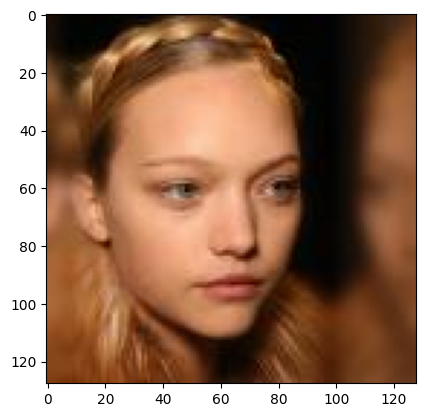

In [13]:
plt.imshow((test_images_X[3]/2 + 0.5)[:,:,::-1])

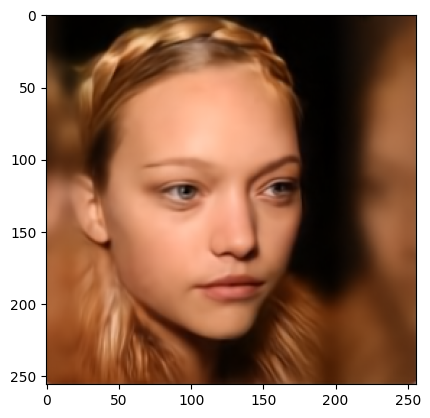

In [14]:
gen_out = generator(test_images_X[3].reshape(1, 128, 128, 3), training=False)
plt.imshow(out_to_img(gen_out))

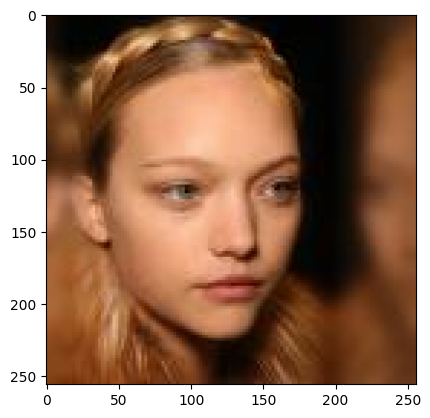

In [15]:
plt.imshow((test_images_X_cv[3]/2 + 0.5)[:,:,::-1])

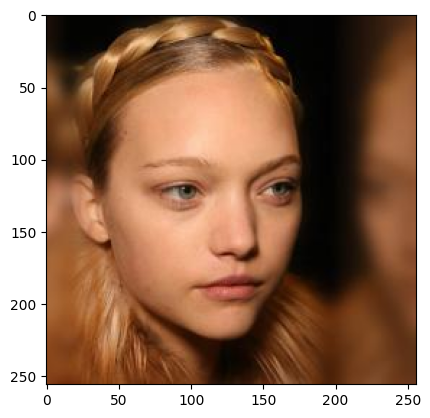

In [16]:
plt.imshow((test_images_y[3]/2 + 0.5)[:,:,::-1])

In [9]:
cv_images = []
target_images = []
gen_images = []

for cv_img, target_img, gen_img in zip(val_X_cv, val_y, val_X):
    cv_img_gs = cv2.cvtColor((cv_img/2 + 0.5)*255, cv2.COLOR_BGR2GRAY)
    cv_images.append(cv_img_gs)
    
    target_img_gs = cv2.cvtColor((target_img/2 + 0.5)*255, cv2.COLOR_BGR2GRAY)
    target_images.append(target_img_gs)
    
    gen_out = generator(gen_img.reshape(1, 128, 128, 3), training=False)
    gen_img_gs = cv2.cvtColor(out_to_img(gen_out)*255, cv2.COLOR_RGB2GRAY)
    gen_images.append(gen_img_gs)
    
cv_images = np.asarray(cv_images, dtype=np.float32)
target_images = np.asarray(target_images, dtype=np.float32)
gen_images = np.asarray(gen_images, dtype=np.float32)

In [36]:
ssim_cv_target_mean = ssim_mean(cv_images, target_images)
ssim_gen_target_mean = ssim_mean(gen_images, target_images)
print(f"Mean SSIM using OpenCV resize and target image: {ssim_cv_target_mean}")
print(f"Mean SSIM using generated image resize and target image: {ssim_gen_target_mean}")

Mean SSIM using OpenCV resize and target image: 0.6865846258217291
Mean SSIM using generated image resize and target image: 0.7274399602957812


In [30]:
distance = norm_1_mean(cv_images, target_images)
print(f"Norm 1 mean distance for OpenCV resize and target image: {distance}")

distance = norm_1_mean(gen_images, target_images)
print(f"Norm 1 mean distance for generated image and target image: {distance}")

distance = norm_2_mean(cv_images, target_images)
print(f"Norm 2 mean distance for OpenCV resize and target image: {distance}")

distance = norm_2_mean(gen_images, target_images)
print(f"Norm 2 mean distance for generated image and target image: {distance}")

Norm 1 mean distance for OpenCV resize and target image: 332801.4375
Norm 1 mean distance for generated image and target image: 297535.96875
Norm 2 mean distance for OpenCV resize and target image: 2179.06689453125
Norm 2 mean distance for generated image and target image: 1801.2052001953125


In [34]:
cv_img = cv2.cvtColor((val_X_cv[1]/2 + 0.5)*255, cv2.COLOR_BGR2GRAY)
target_img = cv2.cvtColor((val_y[1]/2 + 0.5)*255, cv2.COLOR_BGR2GRAY)
gen_out = generator(val_X[1].reshape(1, 128, 128, 3), training=False)
gen_img = cv2.cvtColor(out_to_img(gen_out)*255, cv2.COLOR_RGB2GRAY)

ssim_cv_target = ssim(cv_img, target_img)
ssim_gen_target = ssim(gen_img, target_img)

print(f"SSIM for OpenCV resize and target image: {ssim_cv_target}")
print(f"SSIM for generated image resize and target image: {ssim_gen_target}")

SSIM for OpenCV resize and target image: 0.8132679022134505
SSIM for generated image resize and target image: 0.867609823441677


In [27]:
distance = norm_1(cv_img, target_img)
print(f"Norm 1 distance for OpenCV resize and target image: {distance}")

distance = norm_1(gen_img, target_img)
print(f"Norm 1 distance for generated image and target image: {distance}")

distance = norm_2(cv_img, target_img)
print(f"Norm 2 distance for OpenCV resize and target image: {distance}")

distance = norm_2(gen_img, target_img)
print(f"Norm 2 distance for generated image and target image: {distance}")

Norm 1 distance for OpenCV resize and target image: 397064.90625
Norm 1 distance for generated image and target image: 389197.0
Norm 2 distance for OpenCV resize and target image: 2410.01806640625
Norm 2 distance for generated image and target image: 2288.0166015625
